In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [2]:
import importlib
import sys
sys.path.append('../')
from Utils.perturbationsnew import RBPIndividual, RBPIndividualNew1, RBPIndividualNew2, zeroPerturb, noisePerturb, blurPerturb
from Utils.models import *
from Utils.data import perturb, generateSynthetic, generateSyntheticPerturbReal,ReadTS

print(sys.path)


['/Users/gali/anaconda3/envs/LIMEtf/lib/python310.zip', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/lib-dynload', '', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages/setuptools/_vendor', '../', '../']


## Test important content removal (accuracy decrease)

### Load synthetic dataset and train CNN model 

In [3]:
x_test_original, y_test_original,x_train, y_train = ReadTS('ChlorineConcentration')
y_train = y_train - 1
y_test_original = y_test_original - 1
print(x_train.shape)
print(y_train)

(3840, 166, 1)
[1. 1. 0. ... 2. 2. 2.]


In [4]:
model = make_CNN_model(x_train.shape[1:],num_classes = 3)
trained_model, history = train_CNN_model(model, x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


2024-11-13 20:49:36.771916: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


96/96 [==============================] - 1s 8ms/step - loss: 1.0072 - sparse_categorical_accuracy: 0.5303 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.2526
Epoch 2/100
96/96 [==============================] - 1s 8ms/step - loss: 0.9754 - sparse_categorical_accuracy: 0.5612 - val_loss: 1.2953 - val_sparse_categorical_accuracy: 0.2526
Epoch 3/100
96/96 [==============================] - 1s 8ms/step - loss: 0.9681 - sparse_categorical_accuracy: 0.5651 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.4492
Epoch 4/100
96/96 [==============================] - 1s 8ms/step - loss: 0.9619 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.9972 - val_sparse_categorical_accuracy: 0.5547
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9558 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.9873 - val_sparse_categorical_accuracy: 0.5638
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9555 - sparse_categorical_accuracy: 0.5664

In [5]:
test_loss, test_acc = trained_model.evaluate(x_test_original, y_test_original)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

15/15 [==============================] - 0s 3ms/step - loss: 3.4865 - sparse_categorical_accuracy: 0.4047
Test accuracy 0.40471091866493225
Test loss 3.4865262508392334


### Create perturbed test sets and calculate decrease in accuracy

In [6]:
print(y_test_original.shape)

(467,)


In [7]:
print(inspect.getsource(perturb))
print(inspect.signature(perturb))

def perturb(perturbation_strategy, ts, index0, index1, global_ts = []):
    if perturbation_strategy == 'RBP':
        return RBPIndividual(ts, index0, index1)
    if perturbation_strategy == 'zero':
        return zeroPerturb(ts, index0, index1)
    if perturbation_strategy == 'noise':
        return noisePerturb(ts, index0, index1)
    if perturbation_strategy == 'blur':
        return blurPerturb(ts, index0, index1)
    if perturbation_strategy == 'RBP1':
        return RBPIndividualNew1(global_ts, ts, index0, index1)    
    if perturbation_strategy == 'RBP2':
        return RBPIndividualNew2(global_ts, ts, index0, index1)    

(perturbation_strategy, ts, index0, index1, global_ts=[])


In [23]:
predictions_original = model.predict(x_test_original)
perturb_test_set = x_test_original.copy()
perturb_test_set = perturb_test_set.reshape(x_test_original.shape[0:2])

x_test_rbp = np.asarray([perturb('RBP',x,60,160) for x in perturb_test_set])
x_test_rbp = np.expand_dims(x_test_rbp, axis=-1)
predictions_rbp = model.predict(x_test_rbp)

x_test_new1 = np.asarray([perturb('RBP1',x,60,160, global_ts = perturb_test_set) for x in perturb_test_set])
x_test_new1 = np.expand_dims(x_test_new1, axis=-1)
predictions_new1 = model.predict(x_test_new1)

#x_test_new2 = np.asarray([perturb('RBP2',x,400,500, global_ts = perturb_test_set) for x in perturb_test_set])
#x_test_new2 = np.expand_dims(x_test_new2, axis=-1)
#predictions_new2 = model.predict(x_test_new2)

x_test_zero = np.asarray([perturb('zero',x,60,160) for x in perturb_test_set])
x_test_zero = np.expand_dims(x_test_zero, axis=-1)
predictions_zero = model.predict(x_test_zero)

x_test_noise = np.asarray([perturb('noise',x,60,160) for x in perturb_test_set])
x_test_noise = np.expand_dims(x_test_noise, axis=-1)
predictions_noise = model.predict(x_test_noise)

x_test_blur = np.asarray([perturb('blur',x,60,160) for x in perturb_test_set])
x_test_blur = np.expand_dims(x_test_blur, axis=-1)
predictions_blur = model.predict(x_test_blur)

15/15 [==============================] - 0s 3ms/step


In [24]:
def accuracy(predictions, labels):
    hits = 0
    for i in range(0,len(predictions)):
        if predictions[i] == labels[i]:
            hits += 1
    return hits/len(predictions)

def AveragSuccessRate(predictions, labels):
    hits = 0
    for i in range(0,len(predictions)):
        if predictions[i] != labels[i]:
            hits += 1
    return hits/len(predictions)

In [33]:
def l2norm(perturb):
    # 计算两个数组之间的差
    difference = perturb - x_test_original
    
    # 计算差的平方
    squared_difference = np.square(difference)
    
    # 计算平方和，沿着特征维度（axis=1），因为每个时间序列样本是一行
    sum_of_squares = np.sum(squared_difference, axis=1)
    
    # 计算平方和的平方根，即l2范数
    l2_norms = np.sqrt(sum_of_squares)
    
    average_l2_norm = np.mean(l2_norms)
    
    # l2_norms现在是一个形状为(467,)的数组，其中每个元素代表
    # 对应时间序列样本之间的l2范数
    print(average_l2_norm)  # 输出: (467,)

l2norm(x_test_rbp)
l2norm(x_test_new1)
l2norm(x_test_zero)
l2norm(x_test_noise)
l2norm(x_test_blur)

6.93688572764402
7.0180781941220385
7.063526813065234
578.1805339564735
2.9893885717946818


In [27]:
# 计算两个数组之间的差
difference = x_test_rbp - x_test_original

# 计算差的平方
squared_difference = np.square(difference)

# 计算平方和，沿着特征维度（axis=1），因为每个时间序列样本是一行
sum_of_squares = np.sum(squared_difference, axis=1)

# 计算平方和的平方根，即l2范数
l2_norms = np.sqrt(sum_of_squares)

average_l2_norm = np.mean(l2_norms)

# l2_norms现在是一个形状为(467,)的数组，其中每个元素代表
# 对应时间序列样本之间的l2范数
print(average_l2_norm)  # 输出: (467,)

6.93688572764402


In [31]:
AveragSuccessRate(np.argmax(predictions_new1,axis=1), np.argmax(predictions_original,axis=1))

0.17130620985010706

In [28]:
original_accuracy = accuracy(np.argmax(predictions_original,axis=1), y_test_original)
rbp_accuracy = accuracy(np.argmax(predictions_rbp,axis=1), y_test_original)
new1_accuracy = accuracy(np.argmax(predictions_new1,axis=1), y_test_original)
#new2_accuracy = accuracy(np.argmax(predictions_new2,axis=1), y_test_original)
zero_accuracy = accuracy(np.argmax(predictions_zero,axis=1), y_test_original)
noise_accuracy = accuracy(np.argmax(predictions_noise,axis=1), y_test_original)
blur_accuracy = accuracy(np.argmax(predictions_blur,axis=1), y_test_original)

In [29]:
print(" Original Accuracy: " + str(original_accuracy) + "\n"+
    " RBP Accuracy: " + str(rbp_accuracy) + "\n"+
    " RBP1 Accuracy: " + str(new1_accuracy) + "\n"+
    #" RBP2 Accuracy: " + str(new2_accuracy) + "\n"+
      
    " Zero Accuracy: " + str(zero_accuracy) + "\n"+
    " Noise Accuracy: " + str(noise_accuracy) + "\n"+
    " Blur Accuracy: " + str(blur_accuracy) + "\n")

 Original Accuracy: 0.40471092077087795
 RBP Accuracy: 0.24411134903640258
 RBP1 Accuracy: 0.24411134903640258
 Zero Accuracy: 0.24411134903640258
 Noise Accuracy: 0.24411134903640258
 Blur Accuracy: 0.24411134903640258



In [32]:
print(np.argmax(predictions_rbp,axis=1))
print(y_test_original)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 2. 0. 2. 1. 0. 0. 0. 2. 2. 0. 2. 1. 2. 0. 0. 2. 

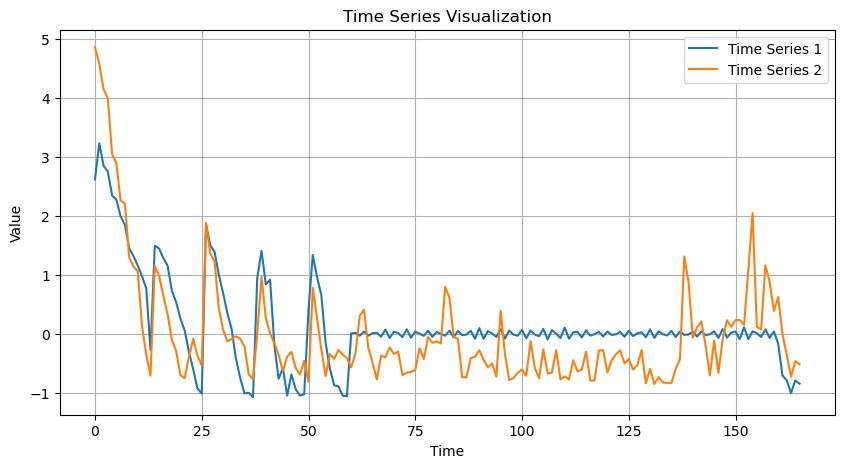

In [21]:
import numpy as np
import matplotlib.pyplot as plt

new1 = x_test_new1[2]
orig = x_test_original[2]

# 创建一个时间轴，对应于时间序列的索引
time_axis = np.arange(len(new1))

# 使用matplotlib绘制时间序列
plt.figure(figsize=(10, 5))  # 设置图形的大小
plt.plot(time_axis, new1, label='Time Series 1')  # 绘制第一个时间序列
plt.plot(time_axis, orig, label='Time Series 2')  # 绘制第二个时间序列

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Time Series Visualization')
plt.xlabel('Time')
plt.ylabel('Value')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()